In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     #seaborn画出的图更好看，且代码更简单，缺点是可塑性差
from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验
from statsmodels.tsa.arima_model import ARIMA
#seaborn 是建立在matplotlib之上的
%matplotlib inline
import pylab
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
pylab.rcParams['figure.figsize'] = (10, 6)   #设置输出图片大小
sns.set(color_codes=True) #seaborn设置背景


F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
F:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = pd.read_excel('E:/postgraduate/案例选题数据及说明/美小麦连续1.xlsx')

In [3]:
data.head()

,时间,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数
0,"2021-01-12,二",636.25,670.00,634.00,664.75,0.0473,0.0567,76800,--,0,19876
1,"2021-01-13,三",665.00,680.75,656.25,659.25,-0.0086,0.0368,76421,--,0,19868
2,"2021-01-14,四",660.00,673.25,653.00,670.50,0.0151,0.0307,57699,--,0,14241
3,"2021-01-15,五",671.00,693.00,664.50,674.75,0.0071,0.0425,75385,--,0,19534
4,"2021-01-19,二",683.75,691.25,668.75,673.25,-0.0033,0.0333,61713,--,0,18738


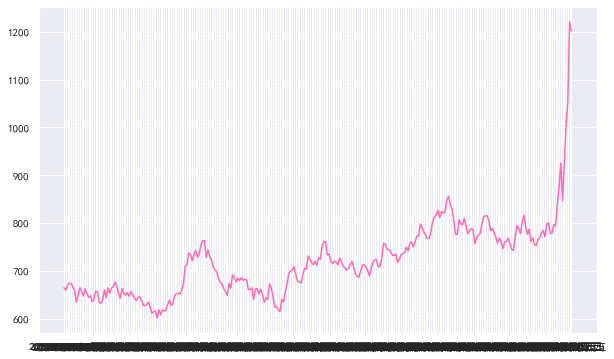

In [6]:
x = data['时间']
y = data['收盘']
plt.plot(x,y,color = 'hotpink')

,开盘,最高,最低,收盘,总手
0,636.25,670.00,634.00,664.75,76800
1,665.00,680.75,656.25,659.25,76421
2,660.00,673.25,653.00,670.50,57699
3,671.00,693.00,664.50,674.75,75385
4,683.75,691.25,668.75,673.25,61713
...,...,...,...,...,...
285,920.25,930.50,885.50,927.75,1049
286,951.00,1004.50,951.00,1004.50,503
287,1009.25,1132.00,997.50,1053.25,355
288,1124.25,1221.00,1119.00,1221.00,173


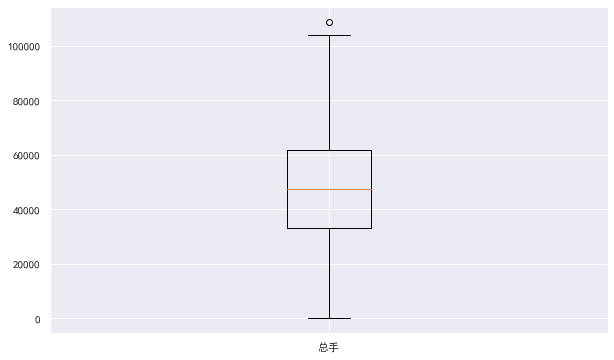

In [23]:
plt.rcParams['font.sans-serif'] = ['SimHei']
data1 = data[['开盘','最高','最低','收盘','总手']]
plt.boxplot(data1['总手'],labels = ['总手'])
data1

In [24]:
upper_lim = data1.总手.mean() +3*data1.总手.std()  ## Removing the outliers
lower_lim = data1.总手.mean() -3*data1.总手.std()

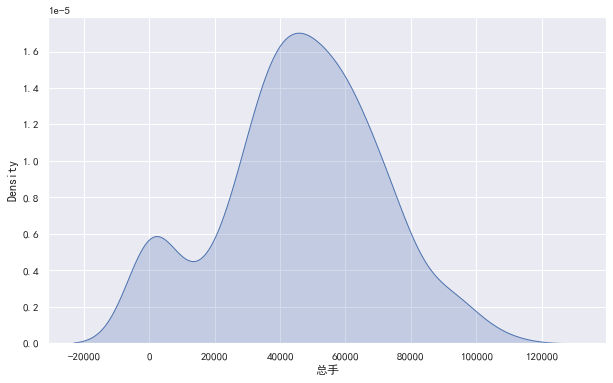

In [26]:
data1 = data1[(data1.总手 > lower_lim) & (data1.总手 < upper_lim)]
fig, ax = plt.subplots()
ax =sns.kdeplot(data1['总手'], shade=True, color="b")

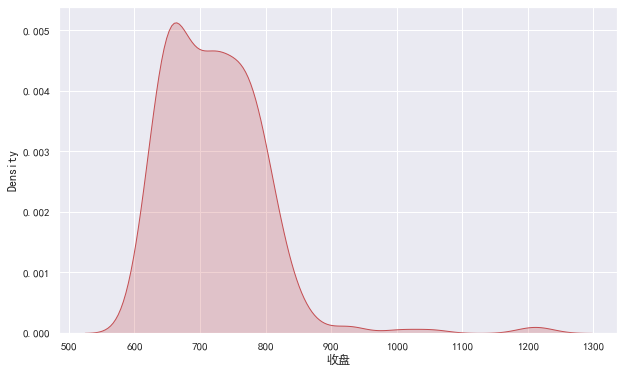

In [28]:
ax = sns.kdeplot(data1['收盘'], shade=True, color="r")

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
mmc = MinMaxScaler()
scaled_data = mmc.fit_transform(data1)
scaled_data = pd.DataFrame(scaled_data , columns = ['开盘','最高','最低','收盘'])
scaled_data

,开盘,最高,最低,收盘
0,0.044791,0.073626,0.066995,0.103184
1,0.083814,0.088489,0.103576,0.094317
2,0.077027,0.078120,0.098233,0.112455
3,0.091958,0.105427,0.117139,0.119307
4,0.109264,0.103007,0.124127,0.116888
...,...,...,...,...
285,0.430268,0.433806,0.480477,0.527207
286,0.472005,0.536122,0.588163,0.650947
287,0.551069,0.712409,0.664612,0.729545
288,0.707160,0.835465,0.864365,1.000000


In [13]:
train1 = scaled_data.iloc[:int(len(data)*0.8)]
test1 = scaled_data.iloc[int(len(data)*0.8):]

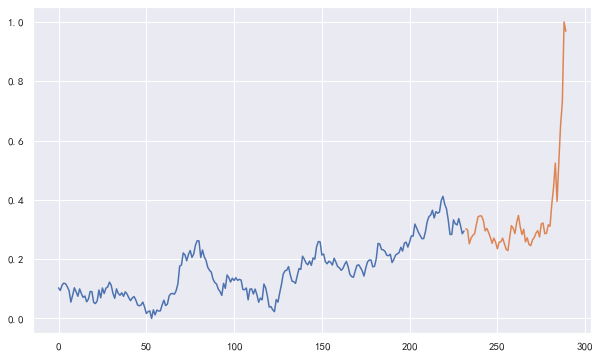

In [17]:
fig,ax = plt.subplots()
ax.plot(train1.收盘)
ax.plot(test1.收盘)

In [18]:
X_train1,X_test1,y_train1,y_test1 = train1.drop('收盘',axis='columns'),test1.drop(['收盘'],axis='columns'),train1['收盘'],test1['收盘']

In [19]:
from tensorflow import keras

In [41]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(3,1)))

    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 16)
    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    model.add(keras.layers.Dense(10))

    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1,1e-2, 1e-3, 1e-4,1e-5]) 

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.MeanAbsoluteError(), 
                metrics = ['accuracy'])

    return model

In [42]:
import keras_tuner as kt
tuner = kt.Hyperband(build_model,
                         objective = 'val_loss', 
                         max_epochs = 10,
                         factor = 3,)

tuner.search(X_train1, y_train1, epochs = 10, validation_data = (X_test1, y_test1))  

Trial 31 Complete [00h 00m 03s]
val_loss: 0.01877993531525135

Best val_loss So Far: 0.01877993531525135
Total elapsed time: 00h 00m 56s
INFO:tensorflow:Oracle triggered exit


In [31]:
!pip install keras_tuner

In [43]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [44]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train1, y_train1, epochs=50, validation_split=0.2)

Epoch 1/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0708 - accuracy: 0.0000e+00 - val_loss: 0.0549 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0377 - accuracy: 0.0000e+00 - val_loss: 0.0802 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - val_loss: 0.0411 - val_accuracy: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 0.0158 - accuracy: 0.0000e+00 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - val_loss: 0.0172 - val_accuracy: 0.0000e+00
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0176 - va

In [45]:
predicted = model.predict(X_test1)
y_test1_np = np.asarray(y_test1)
predicted.shape

(58, 10)

In [54]:
mean_predicted = []
for i in range(len(predicted)):
    value = predicted[i].mean()
    mean_predicted.append(value)


In [55]:
print(len(mean_predicted))
print(len(y_test1_np))

58
58


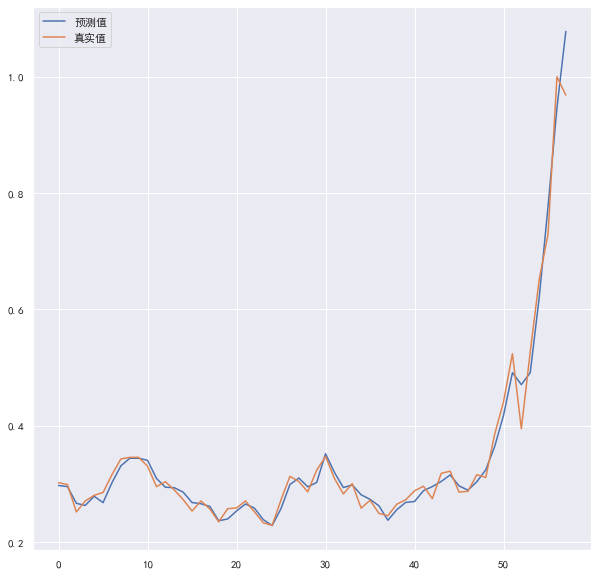

In [56]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(mean_predicted,label = '预测值')
ax.plot(y_test1_np,label = '真实值')
plt.legend(loc="upper left")

In [1]:
# Predicting closing price of Google and microsoft
train_sample = data1["收盘"]
model = sm.tsa.VARMAX(train_sample,order=(2,1),trend='c')
result = model.fit(maxiter=1000,disp=False)
print(result.summary())
predicted_result = result.predict(start=0, end=1000)
result.plot_diagnostics()
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample.iloc[1:1002].values, predicted_result.values))
print("The root mean squared error is {}.".format(rmse))

NameError: name 'data1' is not defined